# MNIST with CNN

Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets,transforms

import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)

train_size = int(0.9*len(train_dataset))
val_size = len(train_dataset)-train_size

train_dataset,val_dataset = torch.utils.data.random_split(
    train_dataset,[train_size,val_size]
)

batch_size=128

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(dataset=val_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,padding=1)

        self.pool = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(64*14*14,128)
        self.fc2 = nn.Linear(128,10)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = x.view(x.size(0),-1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = SimpleCNN().to(device)

print(cnn_model)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [6]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    params=cnn_model.parameters(),
    lr=1e-3
)

In [7]:
def train_one_epoch(model,device,loader,optimizer,criterion):
    model.train()
    running_loss=0.0
    for images,labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()*images.size(0)
    epoch_loss = running_loss/len(loader.dataset)
    return epoch_loss



In [8]:
def evaluate(model,loader,criterion,device):
    model.eval()
    running_loss=0.0
    correct=0
    with torch.no_grad():
        for images,labels in loader:
            images=images.to(device)
            labels=labels.to(device)

            outputs = model(images)
            loss = criterion(outputs,labels)

            running_loss+=loss.item()*images.size(0)

            preds=outputs.argmax(dim=1)
            correct+=(preds==labels).sum().item()
    val_loss = running_loss/len(loader.dataset)
    accuracy = correct/len(loader.dataset)

    return val_loss,accuracy


In [9]:
train_losses_cnn = []
val_losses_cnn=[]
val_acc_cnn = []

num_epochs=10
for epoch in range(num_epochs):
    train_loss = train_one_epoch(
        model=cnn_model,device=device,
        loader=train_loader,optimizer=optimizer,
        criterion=criterion
    )
    val_loss,val_acc = evaluate(
        cnn_model,val_loader,criterion,device
    )

    train_losses_cnn.append(train_loss)
    val_losses_cnn.append(val_loss)
    val_acc_cnn.append(val_acc)

    print(
        f"Epoch {epoch+1} |"
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )
    

Epoch 1 |Train Loss: 0.2340 | Val Loss: 0.0969 | Val Acc: 0.9715
Epoch 2 |Train Loss: 0.0541 | Val Loss: 0.0612 | Val Acc: 0.9825
Epoch 3 |Train Loss: 0.0341 | Val Loss: 0.0491 | Val Acc: 0.9852
Epoch 4 |Train Loss: 0.0243 | Val Loss: 0.0447 | Val Acc: 0.9875
Epoch 5 |Train Loss: 0.0180 | Val Loss: 0.0479 | Val Acc: 0.9845
Epoch 6 |Train Loss: 0.0115 | Val Loss: 0.0581 | Val Acc: 0.9842
Epoch 7 |Train Loss: 0.0100 | Val Loss: 0.0594 | Val Acc: 0.9847
Epoch 8 |Train Loss: 0.0088 | Val Loss: 0.0491 | Val Acc: 0.9867
Epoch 9 |Train Loss: 0.0073 | Val Loss: 0.0564 | Val Acc: 0.9857
Epoch 10 |Train Loss: 0.0067 | Val Loss: 0.0555 | Val Acc: 0.9878


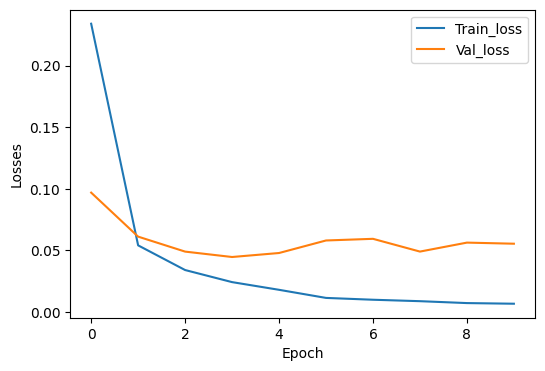

In [10]:
plt.figure(figsize=(6,4))
plt.plot(train_losses_cnn,label="Train_loss")
plt.plot(val_losses_cnn,label="Val_loss")
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.legend()
plt.show()


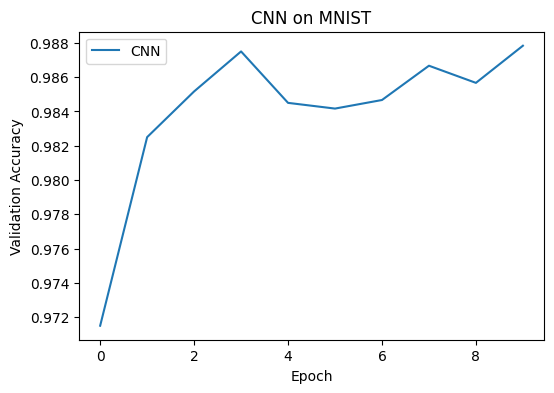

In [11]:
plt.figure(figsize=(6,4))
plt.plot(val_acc_cnn, label="CNN")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.title("CNN on MNIST")
plt.show()
